In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from matplotlib.path import Path
%matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


Cannot import mxnet.


In [2]:
from sklearn.svm import SVC
from sklearn.externals import joblib

In [3]:
def convert_to_surround_name(name_u, suffix):
    return name_u + '_surround_' + suffix

In [4]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [5]:
# structures = ['7N', '12N']
# labels_to_sample = structures + map(convert_to_surround_name, structures)
labels_to_sample = structures + [convert_to_surround_name(l, surr_l) for l in structures for surr_l in structures + ['noclass'] if surr_l not in l]

In [6]:
training_addresses = defaultdict(list)

labels = set([])

for stack in ['MD589', 'MD585', 'MD594']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels = labels | labels_this_stack
    
    training_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, num_samples_per_landmark=1000)
    
    for name_u, addresses in training_addresses_sec_idx.iteritems():
        training_addresses[name_u] += [(stack, ) + addr for addr in addresses]
        
training_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.


In [65]:
# See if we can use location on image frame as feature

# def addresses_to_locations(addresses):
    
#     key_func = lambda (i, (st, se, idx)): st
    
#     locations = []
    
#     for stack, group in groupby(sorted(enumerate(addresses), key=key_func), key=key_func):
#         sample_locations = grid_parameters_to_sample_locations(get_default_gridspec(stack))
#         for i, (st, se, idx) in group:
#             locations.append((i, sample_locations[idx]))
    
#     return [loc for i, loc in sorted(locations)]

In [66]:
# locations = np.array(addresses_to_locations(training_addresses['10N']))

# plt.scatter(locations[:,0], locations[:,1]);
# plt.xlim([0, 15000]);
# plt.ylim([0, 12000]);

In [26]:
training_features = apply_function_to_dict(addresses_to_features, training_addresses)

('MD585', 83)
('MD585', 84)
('MD585', 85)
('MD585', 86)
('MD585', 87)
('MD585', 88)
('MD585', 89)
('MD585', 90)
('MD585', 91)
('MD585', 92)
('MD585', 93)
('MD585', 94)
('MD585', 95)
('MD585', 96)
('MD585', 97)
('MD585', 98)
('MD585', 99)
('MD585', 100)
('MD585', 101)
('MD585', 102)
('MD585', 103)
('MD585', 104)
('MD585', 105)
('MD585', 106)
('MD585', 107)
('MD585', 108)
('MD585', 109)
('MD585', 110)
('MD585', 111)
('MD585', 112)
('MD585', 113)
('MD585', 114)
('MD585', 115)
('MD585', 116)
('MD585', 117)
('MD585', 119)
('MD585', 120)
('MD585', 121)
('MD585', 122)
('MD585', 123)
('MD585', 124)
('MD585', 125)
('MD585', 126)
('MD585', 127)
('MD585', 128)
('MD585', 129)
('MD585', 130)
('MD585', 131)
('MD585', 132)
('MD585', 133)
('MD585', 134)
('MD585', 135)
('MD585', 136)
('MD585', 137)
('MD585', 138)
('MD585', 139)


Patch in annotation but not in mask: MD585 139 MD585-N26-2015.08.19-15.37.53_MD585_1_0076 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @53782


('MD585', 140)
('MD585', 141)
('MD585', 142)
('MD585', 143)
('MD585', 144)
('MD585', 145)
('MD585', 146)
('MD585', 147)
('MD585', 148)
('MD585', 149)
('MD585', 150)
('MD585', 151)


Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @53343
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @50392
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @52722
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @52522
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @55056
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @55259
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo 

('MD585', 152)
('MD585', 153)
('MD585', 154)
('MD585', 155)
('MD585', 156)
('MD585', 157)
('MD585', 158)
('MD585', 159)
('MD585', 160)
('MD585', 161)
('MD585', 162)
('MD585', 163)
('MD585', 164)
('MD585', 165)
('MD585', 166)
('MD585', 167)
('MD585', 168)
('MD585', 169)
('MD585', 170)
('MD585', 171)
('MD585', 172)
('MD585', 173)
('MD585', 174)
('MD585', 175)
('MD585', 176)
('MD585', 177)
('MD585', 178)
('MD585', 179)
('MD585', 180)
('MD585', 181)
('MD585', 182)
('MD585', 183)
('MD585', 184)
('MD585', 185)
('MD585', 186)
('MD585', 187)
('MD585', 188)
('MD585', 189)
('MD585', 190)
('MD585', 191)
('MD585', 192)
('MD585', 193)
('MD585', 194)
('MD585', 195)
('MD585', 196)
('MD585', 197)
('MD585', 198)
('MD585', 199)
('MD585', 200)
('MD585', 201)
('MD585', 202)
('MD585', 203)
('MD585', 204)
('MD585', 205)
('MD585', 206)
('MD585', 207)
('MD585', 208)
('MD585', 209)
('MD585', 210)
('MD585', 211)
('MD585', 212)
('MD585', 213)
('MD585', 214)
('MD585', 215)
('MD585', 216)
('MD585', 217)
('MD585', 

Patch in annotation but not in mask: MD585 225 MD585-N40-2015.07.16-22.14.28_MD585_2_0119 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @25762


('MD585', 226)
('MD585', 227)
('MD585', 228)
('MD585', 229)
('MD585', 230)
('MD585', 231)
('MD585', 232)
('MD585', 233)
('MD585', 234)
('MD585', 235)
('MD585', 236)
('MD585', 237)
('MD585', 238)
('MD585', 239)
('MD585', 240)
('MD585', 241)
('MD585', 242)
('MD585', 243)
('MD585', 244)
('MD585', 245)
('MD585', 246)
('MD585', 247)
('MD585', 248)
('MD585', 249)
('MD585', 250)
('MD585', 251)
('MD585', 252)
('MD585', 253)
('MD585', 254)
('MD585', 255)
('MD585', 256)
('MD585', 257)
('MD585', 258)
('MD585', 259)
('MD585', 260)
('MD585', 261)
('MD585', 262)
('MD585', 263)
('MD585', 264)
('MD585', 265)
('MD585', 266)
('MD585', 267)
('MD585', 269)
('MD585', 270)
('MD585', 271)
('MD585', 272)
('MD585', 273)
('MD585', 274)
('MD585', 275)
('MD585', 276)
('MD585', 277)
('MD585', 278)
('MD585', 279)
('MD585', 280)
('MD585', 281)
('MD585', 282)
('MD585', 283)
('MD585', 284)
('MD585', 285)
('MD585', 286)
('MD585', 287)
('MD585', 288)
('MD585', 289)
('MD585', 290)
('MD585', 291)
('MD585', 292)
('MD585', 

Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @45210
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @44819
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @44626
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @43845
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @44820
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @44040
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_018

('MD594', 274)
('MD594', 275)
('MD594', 276)
('MD594', 277)
('MD594', 278)
('MD594', 279)
('MD594', 280)
('MD594', 281)
('MD594', 282)
('MD594', 283)
('MD594', 284)
('MD594', 285)
('MD594', 286)
('MD594', 287)
('MD594', 288)
('MD594', 289)
('MD594', 290)
('MD594', 291)
('MD594', 292)
('MD594', 293)
('MD594', 294)
('MD594', 295)
('MD594', 296)
('MD594', 297)
('MD594', 298)
('MD594', 299)
('MD594', 300)
('MD594', 301)
('MD594', 302)
('MD594', 303)
('MD594', 304)
('MD594', 305)
('MD594', 306)
('MD594', 307)
('MD594', 308)
('MD594', 309)
('MD594', 310)
('MD594', 311)
('MD594', 312)
('MD594', 313)
('MD594', 314)
('MD594', 315)
('MD594', 316)
('MD594', 317)
('MD594', 318)
('MD594', 319)
('MD594', 320)
('MD594', 321)
('MD594', 322)
('MD594', 323)
('MD594', 324)
('MD594', 325)
('MD594', 326)
('MD594', 327)
('MD594', 328)
('MD594', 329)
('MD594', 330)
('MD594', 331)
('MD594', 332)
('MD594', 333)
('MD594', 334)
('MD594', 335)
('MD594', 336)
('MD594', 337)
('MD594', 338)
('MD594', 339)
('MD594', 

In [41]:
training_features = {name: np.array([f for f in feats if f is not None]) 
                     for name, feats in training_features.iteritems()}

In [42]:
for name in sorted(training_features.iterkeys()):
    print name, len(training_features[name])

10N 2609
10N_surround_12N 3000
10N_surround_AP 367
10N_surround_noclass 3000
12N 3000
12N_surround_10N 2460
12N_surround_AP 161
12N_surround_noclass 3000
3N 3000
3N_surround_4N 246
3N_surround_noclass 3000
4N 474
4N_surround_3N 720
4N_surround_noclass 3000
5N 3000
5N_surround_7n 25
5N_surround_noclass 3000
6N 862
6N_surround_7n 353
6N_surround_noclass 3000
7N 3000
7N_surround_Amb 38
7N_surround_noclass 3000
7n 3000
7n_surround_5N 19
7n_surround_6N 311
7n_surround_noclass 3000
AP 3000
AP_surround_10N 140
AP_surround_12N 204
AP_surround_noclass 3000
Amb 1570
Amb_surround_7N 59
Amb_surround_LRt 160
Amb_surround_noclass 3000
DC 2999
DC_surround_VCA 3000
DC_surround_VCP 3000
DC_surround_noclass 3000
IC 3000
IC_surround_SC 3000
IC_surround_noclass 3000
LC 3000
LC_surround_noclass 3000
LRt 2995
LRt_surround_Amb 109
LRt_surround_Sp5C 71
LRt_surround_noclass 3000
PBG 2717
PBG_surround_SNR 350
PBG_surround_VLL 105
PBG_surround_noclass 3000
Pn 3000
Pn_surround_RtTg 3000
Pn_surround_Tz 8
Pn_surrou

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
train_sample_scheme = 1

In [32]:
# svm_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR + '/trainSampleScheme_%(scheme)d' % {'scheme':train_sample_scheme}))

In [59]:
# train svm classifiers

svm_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'classifiers'))

for label in structures:
            
    print label

    t = time.time()

    features_pos = training_features[label]
    
    if train_sample_scheme == 1:
        features_neg = training_features[convert_to_surround_name(label, 'noclass')]
    elif train_sample_scheme == 2:
        features_neg = np.vstack([training_features[convert_to_surround_name(label, 'noclass')]] + \
                                  [training_features[convert_to_surround_name(label, surr_l)] 
                                  for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
#           probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, 
#           max_iter=-1, decision_function_shape=None, random_state=None)

#     svc = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
#           probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, 
#           max_iter=-1, decision_function_shape=None, random_state=None)
    
#     svc = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', 
#                     fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=100)

    svc = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                             fit_intercept=True, intercept_scaling=1, class_weight=None, 
                             random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                             verbose=0, warm_start=False, n_jobs=1)
    
    svc.fit(train_data, train_labels)
    
    sys.stderr.write('svm train: %.2f seconds\n' % (time.time() - t))
    
#     t = time.time()

    joblib.dump(svc, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})
    
#     sys.stderr.write('svm dump: %.2f seconds\n' % (time.time() - t))
    
#     del features_pos, features_neg, train_data, train_labels, svc

5N


svm train: 6.86 seconds


6N


svm train: 2.53 seconds


7N


svm train: 8.96 seconds


7n


svm train: 5.47 seconds


Amb


svm train: 5.18 seconds


LC


svm train: 11.18 seconds


LRt


svm train: 16.26 seconds


Pn


svm train: 10.61 seconds


Tz


svm train: 7.26 seconds


VLL


svm train: 8.26 seconds


RMC


svm train: 9.54 seconds


SNC


svm train: 9.93 seconds


SNR


svm train: 10.60 seconds


3N


svm train: 5.96 seconds


4N


svm train: 2.12 seconds


Sp5I


svm train: 8.04 seconds


Sp5O


svm train: 11.53 seconds


Sp5C


svm train: 20.77 seconds


PBG


svm train: 11.73 seconds


10N


svm train: 13.14 seconds


VCA


svm train: 9.98 seconds


VCP


svm train: 9.97 seconds


DC


svm train: 16.16 seconds


AP


svm train: 12.26 seconds


12N


svm train: 7.83 seconds


RtTg


svm train: 7.51 seconds


SC


svm train: 11.69 seconds


IC


svm train: 10.69 seconds


In [60]:
train_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'training_features/'))

for name_u, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, name_u + '_trainSampleScheme_%(scheme)d.bp' % dict(scheme=train_sample_scheme)))

In [61]:
# Load pre-computed svm classifiers

svc_allClasses = {}
for label in structures:
    svc_allClasses[label] = joblib.load(SVM_ROOTDIR + '/classifiers/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

In [65]:
training_features = {name_u: bp.unpack_ndarray_file(os.path.join(SVM_ROOTDIR, 'training_features', \
                                 name_u + '_trainSampleScheme_%(scheme)d.bp' % dict(scheme=train_sample_scheme)))
                     for name_u in labels}

In [34]:
# visualize training patches

In [ ]:
patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP'], 'grid_index')

In [ ]:
display_images_in_grids(patches, 5)

In [ ]:
patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP_surround'], 'grid_index')

In [ ]:
display_images_in_grids(patches, 5, titles=sampled_addresses['AP_surround'])

In [ ]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

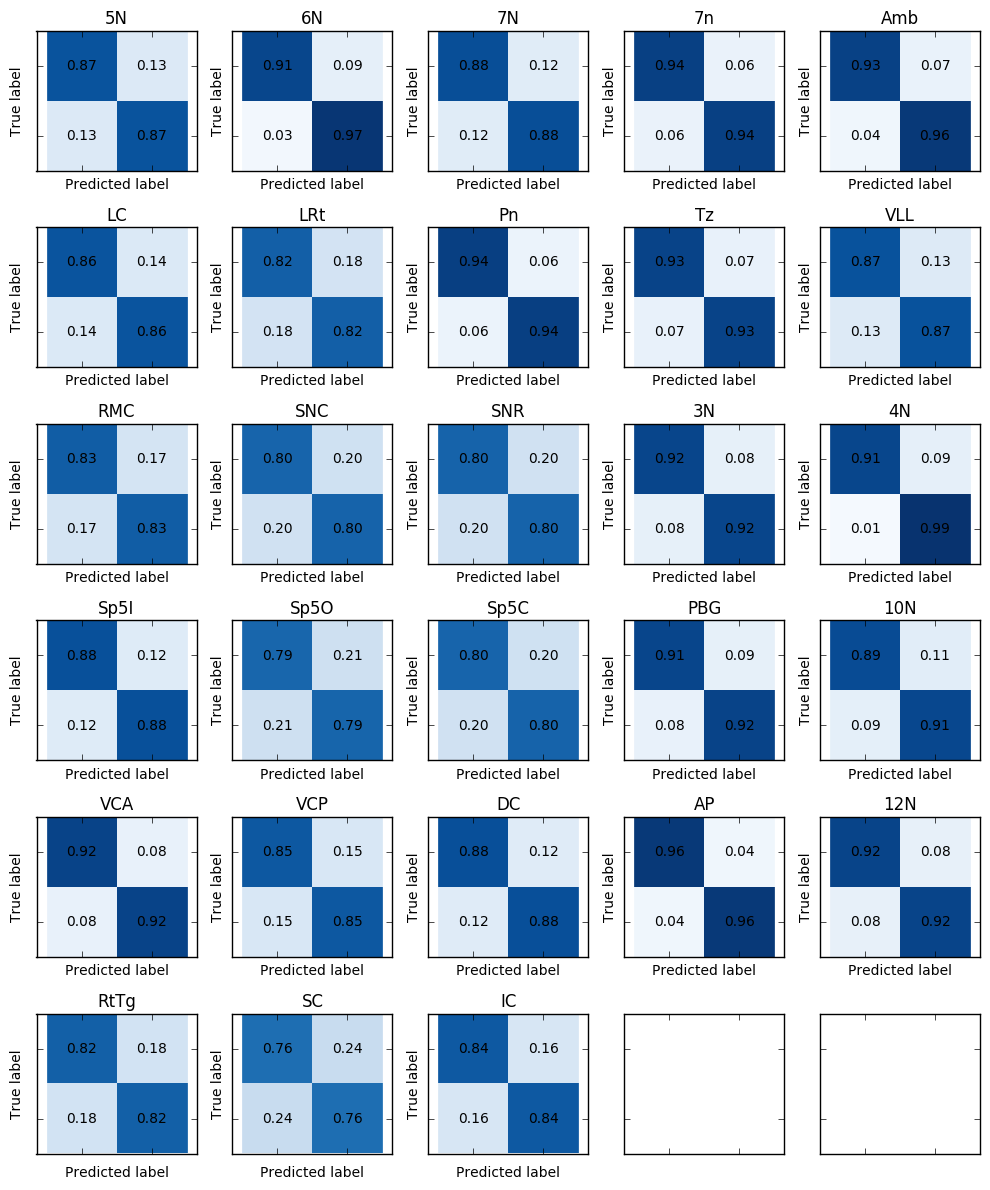

In [66]:
# Compute training accuracy

nrows = len(structures)/5 + 1
ncols = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, label in enumerate(structures):
    
    features_pos = training_features[label]
    
    if train_sample_scheme == 1:
        features_neg = training_features[convert_to_surround_name(label, 'noclass')]
    elif train_sample_scheme == 2:
        features_neg = np.vstack([training_features[convert_to_surround_name(label, 'noclass')]] + \
                                  [training_features[convert_to_surround_name(label, surr_l)] 
                                  for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(train_data)[:, svc.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    plot_confusion_matrix(cm, title='%(label)s'% {'label':label},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [ ]:
# for label in structures:
# # for label in ['AP']:
            
#     print label

#     features_pos = training_features[label]
#     features_neg = training_features[convert_to_surround_name(label)]
    
#     train_data = np.r_[features_pos, features_neg]
#     train_labels = np.r_[np.ones((features_pos.shape[0], )), 
#                          -np.ones((features_neg.shape[0], ))]
    
#     svc = svc_allClasses[label]
    
#     probs = svc.predict_proba(train_data)[:, svc.classes_.tolist().index(1.)]
#     cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
#     plot_confusion_matrix(cm, [label, convert_to_surround_name(label)])
#     plt.show();

In [44]:
# Test

test_addresses = defaultdict(list)

for stack in ['MD589', 'MD585', 'MD594']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices_%(scheme)d.h5' % dict(stack=stack, scheme=train_sample_scheme)    
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    sampled_addresses_sec_idx = sample_locations(label_gridIndices, labels, num_samples_per_landmark=1000)
    
    for name_u, addresses in sampled_addresses_sec_idx.iteritems():
        test_addresses[name_u] += [(stack, ) + addr for addr in addresses]
        
test_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.


In [10]:
test_features = apply_function_to_dict(addresses_to_features, test_addresses)

('MD585', 83)
('MD585', 84)


Patch in annotation but not in mask: MD585 84 MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @28211


('MD585', 85)
('MD585', 86)
('MD585', 87)
('MD585', 88)
('MD585', 89)
('MD585', 90)
('MD585', 91)
('MD585', 92)
('MD585', 93)
('MD585', 94)
('MD585', 95)
('MD585', 96)
('MD585', 97)
('MD585', 98)
('MD585', 99)
('MD585', 100)
('MD585', 101)
('MD585', 102)
('MD585', 103)
('MD585', 104)
('MD585', 105)
('MD585', 106)
('MD585', 107)
('MD585', 108)
('MD585', 109)
('MD585', 110)
('MD585', 111)
('MD585', 112)
('MD585', 113)
('MD585', 114)
('MD585', 115)
('MD585', 116)
('MD585', 117)
('MD585', 119)
('MD585', 120)
('MD585', 121)
('MD585', 122)
('MD585', 123)
('MD585', 124)
('MD585', 125)
('MD585', 126)
('MD585', 127)
('MD585', 128)
('MD585', 129)
('MD585', 130)
('MD585', 131)
('MD585', 132)
('MD585', 133)
('MD585', 134)
('MD585', 135)
('MD585', 136)
('MD585', 137)
('MD585', 138)
('MD585', 139)


Patch in annotation but not in mask: MD585 139 MD585-N26-2015.08.19-15.37.53_MD585_1_0076 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @53568
Patch in annotation but not in mask: MD585 139 MD585-N26-2015.08.19-15.37.53_MD585_1_0076 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @53780


('MD585', 140)
('MD585', 141)
('MD585', 142)
('MD585', 143)
('MD585', 144)
('MD585', 145)
('MD585', 146)
('MD585', 147)
('MD585', 148)
('MD585', 149)
('MD585', 150)
('MD585', 151)


Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @53146
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @52298
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @52082
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @50835
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @54417
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @51438
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo 

('MD585', 152)
('MD585', 153)
('MD585', 154)
('MD585', 155)
('MD585', 156)
('MD585', 157)
('MD585', 158)
('MD585', 159)
('MD585', 160)
('MD585', 161)
('MD585', 162)
('MD585', 163)
('MD585', 164)
('MD585', 165)
('MD585', 166)
('MD585', 167)
('MD585', 168)
('MD585', 169)
('MD585', 170)
('MD585', 171)
('MD585', 172)
('MD585', 173)
('MD585', 174)
('MD585', 175)
('MD585', 176)
('MD585', 177)
('MD585', 178)
('MD585', 179)
('MD585', 180)
('MD585', 181)
('MD585', 182)
('MD585', 183)
('MD585', 184)
('MD585', 185)
('MD585', 186)
('MD585', 187)
('MD585', 188)
('MD585', 189)
('MD585', 190)
('MD585', 191)
('MD585', 192)
('MD585', 193)
('MD585', 194)
('MD585', 195)
('MD585', 196)
('MD585', 197)
('MD585', 198)
('MD585', 199)
('MD585', 200)
('MD585', 201)
('MD585', 202)
('MD585', 203)
('MD585', 204)
('MD585', 205)
('MD585', 206)
('MD585', 207)
('MD585', 208)
('MD585', 209)
('MD585', 210)
('MD585', 211)
('MD585', 212)
('MD585', 213)
('MD585', 214)
('MD585', 215)
('MD585', 216)
('MD585', 217)
('MD585', 

Patch in annotation but not in mask: MD585 332 MD585-IHC58-2015.07.16-18.38.08_MD585_1_0172 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @37038
Patch in annotation but not in mask: MD585 332 MD585-IHC58-2015.07.16-18.38.08_MD585_1_0172 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @35134


('MD585', 333)
('MD585', 334)
('MD585', 335)
('MD585', 336)
('MD585', 337)
('MD585', 338)
('MD585', 339)
('MD585', 340)
('MD585', 341)
('MD585', 342)
('MD585', 343)
('MD585', 344)
('MD585', 345)
('MD585', 346)
('MD585', 347)
('MD585', 348)
('MD585', 349)
('MD585', 350)
('MD589', 94)
('MD589', 95)
('MD589', 96)
('MD589', 97)
('MD589', 98)
('MD589', 99)
('MD589', 100)
('MD589', 101)
('MD589', 102)
('MD589', 103)
('MD589', 104)
('MD589', 105)
('MD589', 106)
('MD589', 107)
('MD589', 108)
('MD589', 109)
('MD589', 110)
('MD589', 111)
('MD589', 112)
('MD589', 113)
('MD589', 114)
('MD589', 115)
('MD589', 116)
('MD589', 117)
('MD589', 119)
('MD589', 120)
('MD589', 121)
('MD589', 122)
('MD589', 123)
('MD589', 124)
('MD589', 125)
('MD589', 126)
('MD589', 127)
('MD589', 128)
('MD589', 129)
('MD589', 130)
('MD589', 131)
('MD589', 132)
('MD589', 133)
('MD589', 134)
('MD589', 135)
('MD589', 136)
('MD589', 137)
('MD589', 138)
('MD589', 139)
('MD589', 140)
('MD589', 141)
('MD589', 142)
('MD589', 143)
(

Patch in annotation but not in mask: MD594 199 MD594-N42-2015.08.26-23.18.56_MD594_1_0124 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @23985


('MD594', 200)
('MD594', 201)
('MD594', 202)
('MD594', 203)
('MD594', 204)
('MD594', 205)
('MD594', 206)
('MD594', 207)
('MD594', 208)
('MD594', 209)
('MD594', 210)
('MD594', 211)
('MD594', 212)
('MD594', 213)
('MD594', 214)
('MD594', 215)
('MD594', 216)
('MD594', 217)
('MD594', 218)
('MD594', 219)
('MD594', 220)
('MD594', 221)
('MD594', 222)
('MD594', 223)
('MD594', 224)
('MD594', 225)
('MD594', 226)
('MD594', 227)
('MD594', 228)
('MD594', 229)
('MD594', 230)
('MD594', 231)
('MD594', 232)
('MD594', 233)
('MD594', 234)
('MD594', 235)
('MD594', 236)
('MD594', 237)
('MD594', 239)
('MD594', 240)
('MD594', 241)
('MD594', 242)
('MD594', 243)
('MD594', 244)
('MD594', 245)
('MD594', 246)
('MD594', 247)


Patch in annotation but not in mask: MD594 247 MD594-N54-2015.08.27-00.02.48_MD594_2_0161 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @21840


('MD594', 248)
('MD594', 249)
('MD594', 250)
('MD594', 251)
('MD594', 252)
('MD594', 253)
('MD594', 254)
('MD594', 255)
('MD594', 256)
('MD594', 257)
('MD594', 258)
('MD594', 259)
('MD594', 260)
('MD594', 262)
('MD594', 263)
('MD594', 264)
('MD594', 265)
('MD594', 266)
('MD594', 267)
('MD594', 268)
('MD594', 269)
('MD594', 270)
('MD594', 271)
('MD594', 272)
('MD594', 273)


Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @43649


('MD594', 274)
('MD594', 275)
('MD594', 276)
('MD594', 277)
('MD594', 278)
('MD594', 279)
('MD594', 280)
('MD594', 281)
('MD594', 282)
('MD594', 283)
('MD594', 284)
('MD594', 285)
('MD594', 286)
('MD594', 287)
('MD594', 288)
('MD594', 289)
('MD594', 290)
('MD594', 291)
('MD594', 292)
('MD594', 293)
('MD594', 294)
('MD594', 295)
('MD594', 296)
('MD594', 297)
('MD594', 298)
('MD594', 299)
('MD594', 300)
('MD594', 301)
('MD594', 302)
('MD594', 303)
('MD594', 304)
('MD594', 305)
('MD594', 306)
('MD594', 307)
('MD594', 308)
('MD594', 309)
('MD594', 310)
('MD594', 311)
('MD594', 312)
('MD594', 313)
('MD594', 314)
('MD594', 315)
('MD594', 316)
('MD594', 317)
('MD594', 318)
('MD594', 319)
('MD594', 320)
('MD594', 321)
('MD594', 322)
('MD594', 323)
('MD594', 324)
('MD594', 325)
('MD594', 326)
('MD594', 327)
('MD594', 328)
('MD594', 329)
('MD594', 330)
('MD594', 331)
('MD594', 332)
('MD594', 333)
('MD594', 334)
('MD594', 335)
('MD594', 336)
('MD594', 337)
('MD594', 338)
('MD594', 339)
('MD594', 

In [11]:
test_features = {name: np.array([f for f in feats if f is not None]) for name, feats in test_features.iteritems()}

Cannot import mxnet.


In [13]:
test_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'test_features'))

for name_u, feats in test_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(test_feat_dir, name_u + '.bp'))

In [ ]:
test_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'test_features'))

test_features = {name_u: bp.unpack_ndarray_file(os.path.join(test_feat_dir, name_u + '.bp'))
                     for name_u in labels_to_sample}

In [1]:
# for label in structures:
            
#     print label

#     features_pos = test_features[label]
#     features_neg = np.vstack([test_features[l] for l in set(labels_to_sample) - set(label)])
    
#     test_data = np.r_[features_pos, features_neg]
#     test_labels = np.r_[np.ones((features_pos.shape[0], )), 
#                          -np.ones((features_neg.shape[0], ))]
    
#     svc = svc_allClasses[label]
    
#     probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
#     cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True)
#     plot_confusion_matrix(cm, [label, 'non-'+label])
#     plt.show();

In [28]:
acc_all_structures = {}

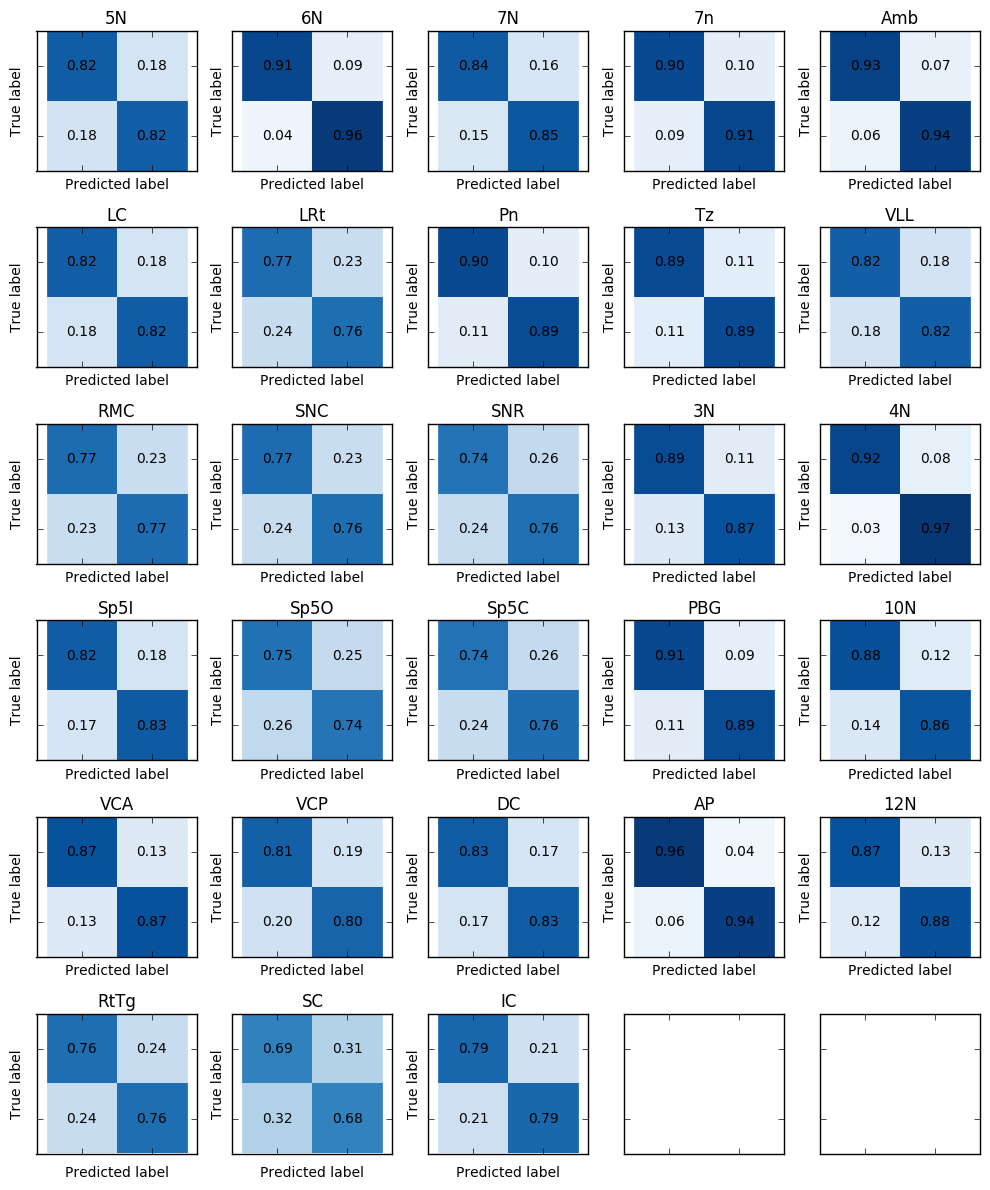

In [29]:
nrows = len(structures)/5 + 1
ncols = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, label in enumerate(structures):
    
    features_pos = test_features[label]
    features_neg = test_features[convert_to_surround_name(label)]
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True)
    
    acc_all_structures[label] = .5 * (cm[0,0] + cm[1,1])
    
    plot_confusion_matrix(cm, title='%(label)s'% {'label':label},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [30]:
np.mean(acc_all_structures.values())

0.8357240846034365

In [ ]:
# Predict full frame

In [ ]:
stack = 'MD591'

filenames_to_sections, sections_to_filenames = DataManager.load_sorted_filenames(stack)
first_sec, last_sec = DataManager.load_cropbox(stack)[4:]
anchor_fn = DataManager.load_anchor_filename(stack)

In [ ]:
def svm_predict(stack, sec):
    fn = sections_to_filenames[sec]
    if fn in ['Nonexisting', 'Rescan', 'Placeholder']:
        return

    feature_fn = PATCH_FEATURES_ROOTDIR + '/%(stack)s/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped_features.hdf' % dict(stack=stack, fn=fn, anchor_fn=anchor_fn)
    
    try:
        features = load_hdf(feature_fn)
    except Exception as e:
        sys.stderr.write(e.message + '\n')
        return
    
    output_dir = create_if_not_exists(os.path.join(SPARSE_SCORES_ROOTDIR, stack, '%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped' % \
                                      {'fn': fn, 'anchor_fn': anchor_fn}))
    
    for label in structures:
        svc = svc_allClasses[label]
        probs = svc.predict_proba(features)[:, svc.classes_.tolist().index(1.)]
        output_fn = output_dir + '/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped_%(label)s_sparseScores.hdf' % \
                    {'fn': fn, 'anchor_fn': anchor_fn, 'label':label}
        bp.pack_ndarray_file(probs, output_fn)

In [ ]:
t = time.time()
# Parallel(n_jobs=8)(delayed(svm_predict)(stack=stack, sec=sec) for sec in range(first_sec, last_sec+1))
Parallel(n_jobs=8)(delayed(svm_predict)(stack=stack, sec=sec) for sec in range(200, 201))
sys.stderr.write('svm predict: %.2f seconds\n' % (time.time() - t)) # 35 s / 10 section; 863 seconds /stack